## Artificial Neural Network Test

<a id='toc'></a>
-----
### TOC


* [Docs](#docs)
* [Predefined Functions and Tests](#general)
* [Minimization](#minimization)
   1. [without Jacobian](#withoutJac)
   2. [Analytical Jacobian](#usingJac)
* [Summary](#summary)


<a id='docs'></a>
-----
### Docs - Example

The problem to solve is the differential equation $$\frac{d}{dt}y(t)= - y(t).$$ Using the network, this is $$y_i= 1+t_i v_k f(t_i w_k+u_k).$$

The procedures are

**Deal with the function first.**
   
1. The cost is $$I=\sum_i\left( \frac{dy_i}{dt}+y_i \right)^2.$$ Our purpose is to minimize this cost.
   
2. To calculate the differential of y, we can write down the explicit expression for it. $$\frac{dy}{dt} = v_k f(t w_k+u_k) + t v_k f(tw_k+u_k) (1-f(tw_k+u_k))w_k,$$ where the function f is defined as a trigf().

3. So the cost becomse $$I = \sum_i \left(  v_k f(t w_k+u_k) + t v_k f(tw_k+u_k) (1-f(tw_k+u_k)) w_k + y \right)^2.$$

<a id='general'></a>
-----
### General Functions

Import Modules used in this notebook

In [88]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
%load_ext snakeviz

import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

import timeit

import pandas as pd

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


Define the general part of cost function

For an first order ODE, $$ L \equiv \frac{d}{dt}y + f(t) =0 ,$$ in which $y(t)$ is the function to be solved.
The cost is defined as $$I = \sum_{i} I_i^2  = I_i * I_i,$$ where 
$$ I_{i} = \left( \frac{d}{dt}y + f(t) \right) $$

Using the following function

In [39]:
def trigf(x):
    #return 1/(1+np.exp(-x)) # It's not bad to define this function here for people could use other functions other than expit(x).
    return expit(x)

In [40]:
## Very important notes
## fOft(x,ti) should be specified, here ti is a scalar value not a list. and it should return a value.
## Here I use t as the variables list and ti as the variable.



def costODE(x,t,initialCondition,fOfArg):   # x is a list of the order v,w,u. x will be splited to three equal parts.
    # initialCondition can only be constants.

    t = np.array(t)
    
    costODETotal = np.sum( costODETList(x,t,initialCondition,fOfArg)  )
        
    return costODETotal
    

def costODETList(x,t,initialCondition,fOfArg):  ## This is the function WITHOUT the square!!! 
    
    v,w,u = np.split(x,3)[:3]
    
    t = np.array(t)
    
    costList = np.asarray([])
    
    for temp in t:
        tempElement = costODETi(x,temp,initialCondition,fOfArg)
        costList = np.append(costList, tempElement)
        
    return np.array(costList)

    

def costODETi(x,ti,initialCondition,fOfArg):  # function for each t. here t is a single value 
    # fOfArg is the function f(t) in the example

    v,w,u = np.split(x,3)[:3]
    
    args = np.array([x,ti,initialCondition])
    
    fvec = np.array(trigf(ti*w + u) )  # This is a vector!!!
    ft = fOfArg(args)  ## fOft should be specified in a problem!!!!!!!!!!!! And it takes a whole array of all the arguments
    # For a given t, this calculates the value of y(t), given the parameters, v, w, u.  Notice this initialCondition.
    
    return  ( np.sum (v*fvec + ti * v* fvec * ( 1 -  fvec  ) * w ) + ft )   ** 2
    

    
## The funNNi(x,ti,initialCondition) takes a time ti and exports the function value with input x.

    
def funNNi(x,ti,initialCondition):  # for a single time stamp t
    
    v,w,u = np.split(x,3)[:3]
    
    return initialCondition +  np.sum(ti * v * trigf( ti*w +u ) )

## funNNList(x,t,initialCondition) takes a list of time and exports the function values of these times.

def funNNList(x,t,initialCondition):
    
    t = np.array(t)
    
    tempList = np.asarray([])
    
    for ti in t:
        tempElement = funNNi(x,ti,initialCondition)
        tempList = np.append(tempList,tempElement)
        
    return np.array(tempList)

An example of the fOfArgs(args) which corresponds to the equation $$\frac{d}{dt}y + y(t)=0 .$$

In [41]:
def yOft(args):
    
    return funNNi(args[0],args[1],args[2])  # As in our definition, args[0] is x, args[1] is ti, args[2] is initialCondition


In [42]:
### This is a test based on the comparison between this notebook and the other one called Basics.ipynb.

testx = np.ones(30)
testt = np.linspace(0,1,2)

print costODE(testx,testt,1,yOft)  ## This is not right, should be 455.812570558
print costODETi(np.ones(9),1,1,yOft)  ## This should be 43.556874613889988

455.812570558
43.5568746139


<a id='minimization'></a>
-----
### Minimizatioin | [toc](#toc)

The example $$\frac{d}{dt}y +y=0$$

In [43]:
def funY(t):

    return np.exp(-t)

<a id='withoutJac'></a>
-----
#### Without Jac

In [44]:
tlin = np.linspace(0,5,11)
initGuess = np.zeros(30)
# initGuess = np.random.rand(1,30)+2

costODEF = lambda x: costODE(x,tlin,1,yOft)

In [45]:
# %%snakeviz
startCG = timeit.default_timer()
costODEFResultCG = minimize(costODEF,initGuess,method="CG")
stopCG = timeit.default_timer()

print stopCG - startCG

print costODEFResultCG

2.75075912476
  status: 2
 success: False
    njev: 15
    nfev: 492
     fun: 0.1920503865598962
       x: array([-0.14291016, -0.14291016, -0.14291016, -0.14291016, -0.14291016,
       -0.14291016, -0.14291016, -0.14291016, -0.14291016, -0.14291016,
       -0.3767748 , -0.3767748 , -0.3767748 , -0.3767748 , -0.3767748 ,
       -0.3767748 , -0.3767748 , -0.3767748 , -0.3767748 , -0.3767748 ,
       -0.00415728, -0.00415728, -0.00415728, -0.00415728, -0.00415728,
       -0.00415728, -0.00415728, -0.00415728, -0.00415728, -0.00415728])
 message: 'Desired error not necessarily achieved due to precision loss.'
     jac: array([-0.03935309, -0.03935309, -0.03935309, -0.03935309, -0.03935309,
       -0.03935308, -0.03935308, -0.03935309, -0.03935309, -0.03935309,
       -0.013696  , -0.013696  , -0.01369601, -0.013696  , -0.01369601,
       -0.013696  , -0.013696  , -0.013696  , -0.013696  , -0.013696  ,
        0.01049041,  0.01049041,  0.01049041,  0.01049041,  0.01049041,
        0.01049

In [46]:
# %%snakeviz
startSLSQP = timeit.default_timer()
costODEFResultSLSQP = minimize(costODEF,initGuess,method="SLSQP")
stopSLSQP = timeit.default_timer()

print stopSLSQP - startSLSQP

print costODEFResultSLSQP

4.81118392944
  status: 0
 success: True
    njev: 51
    nfev: 1649
     fun: 2.5774431624374406e-05
       x: array([-0.48540402, -0.48455081, -0.48705338, -0.26501179, -0.35788204,
       -0.34565228, -0.21748088, -0.18660911, -0.6594982 , -0.27068346,
       -1.2048972 , -1.19990967, -1.21438905, -0.48933447, -0.31391794,
       -0.31977515, -0.38418466, -0.40543151, -0.52481992,  0.01588255,
       -1.25067626, -1.24966621, -1.25259283, -0.92609278, -0.89419533,
       -0.89597664, -0.91608505, -0.92190289, -0.88950163, -0.7106579 ])
 message: 'Optimization terminated successfully.'
     jac: array([  3.94333608e-05,   4.04668297e-05,   3.75074985e-05,
         2.27300134e-04,   1.83917041e-05,   3.09371953e-05,
         1.37970724e-04,   1.62817417e-04,   2.48804897e-04,
        -2.32962982e-03,  -1.01557895e-04,  -1.02731517e-04,
        -9.93060075e-05,   1.37743003e-04,   8.00560364e-04,
         7.43729275e-04,   2.97237345e-04,   2.16706698e-04,
         2.19471341e-04,   3.

In [47]:
# %%snakeviz
startLBFGSB = timeit.default_timer()
# costODEFResult = minimize(costODEF,initGuess,method="Nelder-Mead")
# minimize(costTotalF,initGuess,method="TNC")
costODEFResultLBFGSB = minimize(costODEF,initGuess,method="L-BFGS-B")
stopLBFGSB = timeit.default_timer()

print stopLBFGSB - startLBFGSB

print costODEFResultLBFGSB

10.4770479202
  status: 0
 success: True
    nfev: 119
     fun: 1.6905137501642895e-07
       x: array([-2.0603106 , -2.0603106 , -2.06419974, -2.11583824, -2.0634141 ,
       -2.06405499, -2.06078037, -2.06384378, -2.0830549 , -2.08666077,
       -0.45891181, -0.45891181, -0.20174149, -0.04508755, -0.63243257,
       -0.64959747, -0.51989713, -0.21305195, -0.98190186, -1.07819291,
       -3.00675577, -3.00675577, -2.99724866, -2.89726978, -3.00055964,
       -2.99920211, -3.00596847, -2.99805874, -2.96010668, -2.9544031 ])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ -1.02126515e-05,  -1.02126515e-05,  -1.87774584e-05,
        -2.77189401e-05,  -6.42969453e-06,  -6.13260136e-06,
        -8.71123541e-06,  -1.83276307e-05,  -2.24984889e-06,
        -1.55853109e-06,   5.41300468e-05,   5.41300468e-05,
         7.99575741e-05,   9.91664506e-05,   3.74608826e-05,
         3.60326294e-05,   4.78763702e-05,   7.90094451e-05,
         1.68361325e-05,   1.3764

In [48]:
# %%snakeviz
startNM = timeit.default_timer()
costODEFResultNM = minimize(costODEF,initGuess,method="Nelder-Mead")
stopNM = timeit.default_timer()

print stopNM - startNM

print costODEFResultNM

17.0160830021
  status: 1
    nfev: 6001
 success: False
     fun: 0.00031884090490975285
       x: array([ 0.1330613 ,  1.05982273,  0.18777729, -0.60789078, -0.96393469,
       -0.65270373, -1.55257864,  0.8002259 , -0.12414033, -0.21230861,
       -0.88629202,  0.47527367,  0.21401419,  0.2130512 , -1.5236408 ,
        1.35208616, -0.48922234, -0.85850735,  0.72135512, -1.03407686,
        2.29041152,  0.91184671, -0.56987761,  0.16597395, -0.43267372,
        2.1772668 , -0.1318482 , -0.80817762,  0.44533168, -0.28545885])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 5029


In [49]:
# %%snakeviz
startTNC = timeit.default_timer()
# costODEFResult = minimize(costODEF,initGuess,method="Nelder-Mead")
costODEFResultTNC = minimize(costODEF,initGuess,method="TNC")
stopTNC = timeit.default_timer()

print stopTNC - startTNC

print costODEFResultTNC

26.2406368256
  status: 3
 success: False
    nfev: 300
     fun: 0.0014134200168788226
       x: array([-0.20190472, -0.20190472, -0.18808703, -0.19295435, -0.19572038,
       -0.04796784, -0.19396957, -0.21892287, -0.21447547, -0.17392687,
       -1.67899527, -1.67899527, -0.42007525, -0.91695886, -1.19221734,
        0.22111673, -0.25818086, -0.88921753, -0.46715631, -0.19627801,
        0.20087304,  0.20087304,  0.65713399, -0.05456812,  0.22742078,
        0.15573394,  0.0956364 , -0.20943573,  0.24956391,  0.13324245])
 message: 'Max. number of function evaluations reach'
     jac: array([ 0.00101461,  0.00101461, -0.00061286,  0.00456347,  0.00292545,
       -0.0167402 , -0.00407698,  0.00421885,  0.00257763, -0.00631483,
        0.00024155,  0.00024155,  0.00862044, -0.00134179, -0.00182214,
        0.00145435,  0.00664002, -0.00121416,  0.00651105,  0.00539998,
        0.00070286,  0.00070286,  0.0010624 , -0.00067795, -0.00029385,
        0.00021479,  0.00098624, -0.00069649,

In [50]:
### This method is extremely slow
# %%snakeviz
# startPowell = timeit.default_timer()
# costODEFResultPowell = minimize(costODEF,initGuess,method="Powell")
# stopPowell = timeit.default_timer()

# print stopPowell - startPowell

# print costODEFResultPowell

In [51]:
# for L-BFGS-B method

# print "Success is", costODEFResult.get('success'), "\n", "# of function evaluations", costODEFResult.get('nfev'), "\n",\
# "value of minimized function", costODEFResult.get('fun'), "\n","# of iter", costODEFResult.get('nit')
#
# print "x is\n", costODEFResult.get('x')

In [52]:
print funNNList(np.array( costODEFResultCG.get('x') ),tlin,1)
print funNNList(np.array( costODEFResultSLSQP.get('x') ),tlin,1)
print funNNList(np.array( costODEFResultLBFGSB.get('x') ),tlin,1)
print funNNList(np.array( costODEFResultNM.get('x') ),tlin,1)

[  1.00000000e+00   6.77014463e-01   4.19924637e-01   2.25297162e-01
   8.78206321e-02   8.04407022e-04  -4.32511996e-02  -5.20970637e-02
  -3.32556540e-02   6.34133845e-03   6.05864590e-02]
[ 1.          0.60517646  0.36711424  0.22343151  0.13558498  0.08159165
  0.04879234  0.02940344  0.01824505  0.01166132  0.00700062]
[ 1.          0.60641483  0.3678138   0.22314944  0.13534572  0.08203464
  0.04970017  0.03013128  0.0183094   0.01115312  0.00676784]
[ 1.          0.60129567  0.36281266  0.22220159  0.13660322  0.08295539
  0.04904241  0.02817986  0.01636935  0.01048205  0.00741821]


In [53]:
tlinplt = np.linspace(0,5,20)
tlinplt2 = np.linspace(0,40,50)
plt.figure(figsize=(20,12.35))
plt.plot(tlinplt,funY(tlinplt),'g-', label = "pltAnalytical")
plt.plot(tlinplt,funNNList(np.array( costODEFResultCG.get('x') ),tlinplt,1),'c^',label = "pltODEFResultCG")
plt.plot(tlinplt,funNNList(np.array( costODEFResultSLSQP.get('x') ),tlinplt,1),'r+',label="pltODEFResultSLSQP")
plt.plot(tlinplt,funNNList(np.array( costODEFResultLBFGSB.get('x') ),tlinplt,1),'bo',label="pltODEFResultLBFGSB")
plt.plot(tlinplt,funNNList(np.array( costODEFResultNM.get('x') ),tlinplt,1),'m1',label="pltODEFResultNM")
# plt.yscale('log')
# plt.legend()
# plt.show()


##############
# plot using plot.ly

# figMethodTest = plt.gcf()

# Send figure object to Plotly, show result in notebook
# py.iplot_mpl(figMethodTest,filename="ANN-test-figMethodTest")
py.iplot_mpl(plt.gcf(),filename="ANN-test-figMethodTest")

In [54]:
# Let's not worry about that.

# plt.figure(figsize=(20,12.35))
# plt.plot(tlinplt2,funY(tlinplt2),'g-', label = "pltAnalytical")
# plt.plot(tlinplt2,funNNList(np.array( costODEFResultSLSQP.get('x') ),tlinplt2,1),'r+',label="pltODEFResultSLSQP")
# plt.plot(tlinplt2,funNNList(np.array( costODEFResultLBFGSB.get('x') ),tlinplt2,1),'bo',label="pltODEFResultLBFGSB")

# plt.yscale('log')
# plt.legent()
# plt.show()

# py.iplot_mpl(plt.gcf(),filename="ANN-test-figMethodTest2")

<a id='usingJac'></a>
-----
#### Using Jac

In [55]:
def mhelper(v,w,u,t): ## This function should output a result ## t is a number in this function not array!!
    v = np.array(v)
    w = np.array(w)
    u = np.array(u)
    
    return np.sum( v*trigf( t*w + u )  + t* v* trigf(t*w  + u) * ( 1 -  trigf( t*w +u)  ) * w ) + ( 1 +  np.sum( t * v * trigf( t*w +u ) )  )  
    # Checked # Pass
    
def vhelper(v,w,u,t):
    v = np.array(v)
    w = np.array(w)
    u = np.array(u)
    
    return trigf(t*w+u) + t*trigf(t*w+u)*( 1-trigf(t*w+u) )*w + t*trigf(t*w+u)

def whelper(v,w,u,t):
    v = np.array(v)
    w = np.array(w)
    u = np.array(u)
    
    return v*t*trigf(t*w+u)*( 1- trigf(t*w+u) ) + t*v*( trigf(t*w+u)*(1-trigf(t*w+u))*t* (1-trigf(t*w+u)) )*w - t*v*trigf(t*w+u)*trigf(t*w+u)*(1-trigf(t*w+u))*t*w + t*v*trigf(t*w+u)*(1-trigf(t*w+u))  + t*v*trigf(t*w+u)*(1-trigf(t*w+u))*t    

def uhelper(v,w,u,t):
    v = np.array(v)
    w = np.array(w)
    u = np.array(u)
    
    return v*trigf(t*w+u)*( 1 - trigf(t*w+u)) + t* v * trigf(t*w+u) * (1-trigf(t*w+u))*(1-trigf(t*w+u))*w - t*v*trigf(t*w+u)*trigf(t*w+u)*(1-trigf(t*w+u))*w + t*v*trigf(t*w+u)*(1-trigf(t*w+u))


In [56]:
def costJac(v,w,u,t):
    v = np.array(v)
    w = np.array(w)
    u = np.array(u)
    
    vout = 0
    wout = 0
    uout = 0
    
    for temp in t:
        vout = vout + 2*mhelper(v,w,u,temp)*vhelper(v,w,u,temp)
        wout = wout + 2*mhelper(v,w,u,temp)*whelper(v,w,u,temp)
        uout = uout + 2*mhelper(v,w,u,temp)*uhelper(v,w,u,temp)
    
    out = np.hstack((vout,wout,uout))
    
    return np.array(out)


In [57]:
costODEJacF = lambda x: costJac(np.split(x,3)[0],np.split(x,3)[1],np.split(x,3)[2],tlin)
initGuessJ = np.zeros(30)
# initGuessJ = np.random.rand(1,30)+2

In [58]:
# %%snakeviz
startJacNCG = timeit.default_timer()
costODEResultJacNCG = minimize(costODEF,initGuessJ,method="Newton-CG",jac=costODEJacF)
stopJacNCG = timeit.default_timer()

print stopJacNCG - startJacNCG
print costODEResultJacNCG

28.8225519657
  status: 0
 success: True
    njev: 4178
    nfev: 548
     fun: 0.09398293779213696
       x: array([-31.20588236, -31.20588236, -31.20588236, -31.20588236,
       -31.20588236, -31.20588236, -31.20588236, -31.20588236,
       -31.20588236, -31.20588236,  -0.28889755,  -0.28889755,
        -0.28889755,  -0.28889755,  -0.28889755,  -0.28889755,
        -0.28889755,  -0.28889755,  -0.28889755,  -0.28889755,
        -5.9568862 ,  -5.9568862 ,  -5.9568862 ,  -5.9568862 ,
        -5.9568862 ,  -5.9568862 ,  -5.9568862 ,  -5.9568862 ,
        -5.9568862 ,  -5.9568862 ])
 message: 'Optimization terminated successfully.'
    nhev: 0
     jac: array([  7.71837928e-06,   7.71837928e-06,   7.71837928e-06,
         7.71837928e-06,   7.71837928e-06,   7.71837928e-06,
         7.71837928e-06,   7.71837928e-06,   7.71837928e-06,
         7.71837928e-06,  -6.89322453e-04,  -6.89322453e-04,
        -6.89322453e-04,  -6.89322453e-04,  -6.89322453e-04,
        -6.89322453e-04,  -6.8932245

A test of the results

In [59]:
# for NCG method

print "Success is", costODEResultJacNCG.get('success'), "\n", "# of function evaluations", costODEResultJacNCG.get('nfev'), "\n",\
"value of minimized function", costODEResultJacNCG.get('fun'), "\n","# of iter", costODEResultJacNCG.get('nit')

print "x is\n", costODEResultJacNCG.get('x')

Success is True 
# of function evaluations 548 
value of minimized function 0.0939829377921 
# of iter None
x is
[-31.20588236 -31.20588236 -31.20588236 -31.20588236 -31.20588236
 -31.20588236 -31.20588236 -31.20588236 -31.20588236 -31.20588236
  -0.28889755  -0.28889755  -0.28889755  -0.28889755  -0.28889755
  -0.28889755  -0.28889755  -0.28889755  -0.28889755  -0.28889755
  -5.9568862   -5.9568862   -5.9568862   -5.9568862   -5.9568862
  -5.9568862   -5.9568862   -5.9568862   -5.9568862   -5.9568862 ]


In [60]:
# %%snakeviz
startJacCG = timeit.default_timer()
costODEResultJacCG = minimize(costODEF,initGuessJ,method="CG",jac=costODEJacF)
stopJacCG = timeit.default_timer()

print stopJacCG - startJacCG
print costODEResultJacCG

0.170196056366
  status: 2
 success: False
    njev: 15
    nfev: 27
     fun: 0.1920504147526792
       x: array([-0.1429102 , -0.1429102 , -0.1429102 , -0.1429102 , -0.1429102 ,
       -0.1429102 , -0.1429102 , -0.1429102 , -0.1429102 , -0.1429102 ,
       -0.37677492, -0.37677492, -0.37677492, -0.37677492, -0.37677492,
       -0.37677492, -0.37677492, -0.37677492, -0.37677492, -0.37677492,
       -0.00415729, -0.00415729, -0.00415729, -0.00415729, -0.00415729,
       -0.00415729, -0.00415729, -0.00415729, -0.00415729, -0.00415729])
 message: 'Desired error not necessarily achieved due to precision loss.'
     jac: array([-0.03935216, -0.03935216, -0.03935216, -0.03935216, -0.03935216,
       -0.03935216, -0.03935216, -0.03935216, -0.03935216, -0.03935216,
       -0.01369694, -0.01369694, -0.01369694, -0.01369694, -0.01369694,
       -0.01369694, -0.01369694, -0.01369694, -0.01369694, -0.01369694,
        0.01049026,  0.01049026,  0.01049026,  0.01049026,  0.01049026,
        0.01049

In [61]:
# %%snakeviz
startJacSLSQP = timeit.default_timer()
costODEResultJacSLSQP = minimize(costODEF,initGuessJ,method="SLSQP",jac=costODEJacF)
stopJacSLSQP = timeit.default_timer()

print stopJacSLSQP - startJacSLSQP
print costODEResultJacSLSQP

0.570199966431
  status: 0
 success: True
    njev: 51
    nfev: 66
     fun: 1.080248266970841e-05
       x: array([-1.14137679, -0.94627375, -0.87087044, -1.01525169, -1.09187733,
       -1.18014787, -1.19580593, -1.23912592, -1.31330351, -1.36371235,
       -0.36628767, -0.16915114,  0.02718512, -0.21314756, -0.28643278,
       -0.44737585, -0.48474124, -0.60405077, -0.89880536, -1.23277504,
       -2.35587854, -2.53950768, -2.6062629 , -2.47658718, -2.40362568,
       -2.31855785, -2.30356691, -2.26261292, -2.19727012, -2.16279234])
 message: 'Optimization terminated successfully.'
     jac: array([ -1.54062257e-04,  -1.88647024e-04,  -2.26829058e-04,
        -1.86997132e-04,  -1.75526822e-04,  -1.28483659e-04,
        -1.16205693e-04,  -7.76984490e-05,  -6.92506587e-06,
         1.96097088e-05,   4.29105762e-04,   2.62610025e-04,
         2.46523021e-04,   3.12471903e-04,   3.82432081e-04,
         4.48266944e-04,   4.47819412e-04,   4.12766626e-04,
         2.12299593e-04,   1.48

In [62]:
# %%snakeviz
startJacLBFGSB = timeit.default_timer()
costODEResultJacLBFGSB = minimize(costODEF,initGuessJ,method="L-BFGS-B",jac=costODEJacF)
stopJacLBFGSB = timeit.default_timer()

print stopJacLBFGSB - startJacLBFGSB
print costODEResultJacLBFGSB

5.17962908745
  status: 0
 success: True
    nfev: 466
     fun: 0.093712249132977959
       x: array([-247.62057116, -247.62057116, -247.62057116, -247.62057116,
       -247.62057116, -247.62057116, -247.62057116, -247.62057116,
       -247.62057116, -247.62057116,   -0.28867261,   -0.28867261,
         -0.28867261,   -0.28867261,   -0.28867261,   -0.28867261,
         -0.28867261,   -0.28867261,   -0.28867261,   -0.28867261,
         -8.02983967,   -8.02983967,   -8.02983967,   -8.02983967,
         -8.02983967,   -8.02983967,   -8.02983967,   -8.02983967,
         -8.02983967,   -8.02983967])
 message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     jac: array([  2.15718599e-08,   2.15718599e-08,   2.15718599e-08,
         2.15718599e-08,   2.15718599e-08,   2.15718599e-08,
         2.15718599e-08,   2.15718599e-08,   2.15718599e-08,
         2.15718599e-08,  -5.22190220e-06,  -5.22190220e-06,
        -5.22190220e-06,  -5.22190220e-06,  -5.22190220e-06,
        -5.22190220e-

In [63]:
initGuessJ2 = np.zeros(30)
tlin2 = np.linspace(0,5,100)
costODEJacF2 = lambda x: costJac(np.split(x,3)[0],np.split(x,3)[1],np.split(x,3)[2],tlin2)
costODEF2 = lambda x: costODE(x,tlin2,1,yOft)

initGuessJ3 = np.zeros(30)
tlin3 = np.linspace(0,5,5)
costODEJacF3 = lambda x: costJac(np.split(x,3)[0],np.split(x,3)[1],np.split(x,3)[2],tlin3)
costODEF3 = lambda x: costODE(x,tlin3,1,yOft)


In [64]:
# %%snakeviz
startJacLBFGSB2 = timeit.default_timer()
costODEResultJacLBFGSB2 = minimize(costODEF2,initGuessJ2,method="L-BFGS-B",jac=costODEJacF2)
stopJacLBFGSB2 = timeit.default_timer()

print stopJacLBFGSB2 - startJacLBFGSB2
print costODEResultJacLBFGSB2

132.125494957
  status: 0
 success: True
    nfev: 1644
     fun: 0.59402660993173084
       x: array([ -6.09970583e+03,  -6.09970583e+03,  -6.09970583e+03,
        -6.09970583e+03,  -6.09970583e+03,  -6.09970583e+03,
        -6.09970583e+03,  -6.09970583e+03,  -6.09970583e+03,
        -6.09970583e+03,  -2.83950110e-01,  -2.83950110e-01,
        -2.83950110e-01,  -2.83950110e-01,  -2.83950110e-01,
        -2.83950110e-01,  -2.83950110e-01,  -2.83950110e-01,
        -2.83950110e-01,  -2.83950110e-01,  -1.12626969e+01,
        -1.12626969e+01,  -1.12626969e+01,  -1.12626969e+01,
        -1.12626969e+01,  -1.12626969e+01,  -1.12626969e+01,
        -1.12626969e+01,  -1.12626969e+01,  -1.12626969e+01])
 message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     jac: array([  1.37439344e-09,   1.37439344e-09,   1.37439344e-09,
         1.37439344e-09,   1.37439344e-09,   1.37439344e-09,
         1.37439344e-09,   1.37439344e-09,   1.37439344e-09,
         1.37439344e-09,   2.09065112e-

In [65]:
# %%snakeviz
startJacLBFGSB3 = timeit.default_timer()
costODEResultJacLBFGSB3 = minimize(costODEF3,initGuessJ3,method="L-BFGS-B",jac=costODEJacF3)
stopJacLBFGSB3 = timeit.default_timer()

print stopJacLBFGSB3 - startJacLBFGSB3
print costODEResultJacLBFGSB3

2.09725189209
  status: 0
 success: True
    nfev: 481
     fun: 0.063449481315827297
       x: array([ -4.01464350e+02,  -4.01464350e+02,  -4.01464350e+02,
        -4.01464350e+02,  -4.01464350e+02,  -4.01464350e+02,
        -4.01464350e+02,  -4.01464350e+02,  -4.01464350e+02,
        -4.01464350e+02,  -2.95997459e-01,  -2.95997459e-01,
        -2.95997459e-01,  -2.95997459e-01,  -2.95997459e-01,
        -2.95997459e-01,  -2.95997459e-01,  -2.95997459e-01,
        -2.95997459e-01,  -2.95997459e-01,  -8.46635757e+00,
        -8.46635757e+00,  -8.46635757e+00,  -8.46635757e+00,
        -8.46635757e+00,  -8.46635757e+00,  -8.46635757e+00,
        -8.46635757e+00,  -8.46635757e+00,  -8.46635757e+00])
 message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     jac: array([  6.19175223e-09,   6.19175223e-09,   6.19175223e-09,
         6.19175223e-09,   6.19175223e-09,   6.19175223e-09,
         6.19175223e-09,   6.19175223e-09,   6.19175223e-09,
         6.19175223e-09,   7.76604365e-

In [66]:
# %%snakeviz
startJacSLSQP2 = timeit.default_timer()
costODEResultJacSLSQP2 = minimize(costODEF2,initGuessJ2,method="SLSQP",jac=costODEJacF2)
stopJacSLSQP2 = timeit.default_timer()

print stopJacSLSQP2 - startJacSLSQP2
print costODEResultJacSLSQP2

4.7097029686
  status: 0
 success: True
    njev: 50
    nfev: 85
     fun: 0.00015456941229943612
       x: array([-0.32264221, -0.48107001, -0.04941097, -0.22179986, -0.32500703,
       -0.26811866, -0.16689592, -0.29099586, -0.28023271,  0.35581623,
       -2.13215359, -0.19907189, -0.44445211, -0.83605933, -1.57465365,
       -1.0165954 , -0.20845835, -0.09278176,  0.4425471 ,  0.73163168,
       -0.79214907, -0.0083873 ,  0.07852109,  0.05472123, -0.24917395,
        0.00498926,  0.07293642, -0.08552639, -0.41189544, -0.94173643])
 message: 'Optimization terminated successfully.'
     jac: array([  5.86155143e-04,   1.76026318e-03,   1.06070592e-03,
        -5.63759577e-06,  -5.99931515e-05,  -1.15979657e-04,
         1.82416397e-03,   2.02892373e-03,   3.55605356e-03,
         4.43492803e-03,   3.06517195e-04,  -1.50612327e-03,
        -1.77555087e-04,  -2.62277898e-04,   2.54115876e-05,
        -7.49442817e-05,  -5.24330569e-04,  -1.06579689e-03,
        -1.14473878e-03,   2.052

In [67]:
# %%snakeviz
startJacSLSQP3 = timeit.default_timer()
costODEResultJacSLSQP3 = minimize(costODEF3,initGuessJ3,method="SLSQP",jac=costODEJacF3)
stopJacSLSQP3 = timeit.default_timer()

print stopJacSLSQP3 - startJacSLSQP3
print costODEResultJacSLSQP3

0.312636137009
  status: 0
 success: True
    njev: 67
    nfev: 87
     fun: 1.9284071715143801e-06
       x: array([-2.6109115 , -2.57599424, -2.58878461, -2.57940213, -2.59059415,
       -2.59852687, -2.59236843, -2.61274745, -2.6048374 , -2.6027068 ,
       -0.06868534, -0.13921381, -0.41686679, -0.17524607, -0.47645344,
       -0.69273789, -0.53162242, -0.94586645, -0.81984537, -0.7802183 ,
       -3.23122383, -3.25291901, -3.2255435 , -3.24481987, -3.2221723 ,
       -3.20718217, -3.21886615, -3.17908483, -3.19486312, -3.19905495])
 message: 'Optimization terminated successfully.'
     jac: array([ -1.59890302e-05,  -8.27722239e-06,  -3.19991413e-06,
        -6.09584424e-06,  -3.56792170e-06,  -4.10967168e-06,
        -3.88109099e-06,  -2.08827414e-06,  -3.41089909e-06,
        -3.70672787e-06,   3.73531400e-04,   1.90783426e-04,
        -1.43706761e-05,   1.31844527e-04,  -1.55772645e-05,
         7.43164027e-06,  -1.21567161e-05,   3.33575815e-05,
         2.26259113e-05,   1.8

In [68]:
# %%snakeviz
startJacTNC = timeit.default_timer()
costODEResultJacTNC = minimize(costODEF,initGuessJ,method="TNC",jac=costODEJacF)
stopJacTNC = timeit.default_timer()

print stopJacTNC - startJacTNC
print costODEResultJacTNC

2.67713308334
  status: 3
 success: False
    nfev: 300
     fun: 0.094505048071264891
       x: array([-11.81688438, -11.81688438, -11.81688438, -11.81688438,
       -11.81688438, -11.81688438, -11.81688438, -11.81688438,
       -11.81688438, -11.81688438,  -0.28973009,  -0.28973009,
        -0.28973009,  -0.28973009,  -0.28973009,  -0.28973009,
        -0.28973009,  -0.28973009,  -0.28973009,  -0.28973009,
        -4.98217919,  -4.98217919,  -4.98217919,  -4.98217919,
        -4.98217919,  -4.98217919,  -4.98217919,  -4.98217919,
        -4.98217919,  -4.98217919])
 message: 'Max. number of function evaluations reach'
     jac: array([ 0.00017029,  0.00017029,  0.00017029,  0.00017029,  0.00017029,
        0.00017029,  0.00017029,  0.00017029,  0.00017029,  0.00017029,
       -0.00833811, -0.00833811, -0.00833811, -0.00833811, -0.00833811,
       -0.00833811, -0.00833811, -0.00833811, -0.00833811, -0.00833811,
       -0.00192607, -0.00192607, -0.00192607, -0.00192607, -0.00192607,
  

In [69]:
print funNNList(np.array( costODEResultJacNCG.get('x') ),tlin,1)
print funNNList(np.array( costODEResultJacCG.get('x') ),tlin,1)
print funNNList(np.array( costODEResultJacLBFGSB.get('x') ),tlin,1)
print funNNList(np.array( costODEResultJacTNC.get('x') ),tlin,1)
print funNNList(np.array( costODEResultJacSLSQP.get('x') ),tlin,1)
print funNNList(np.array( costODEResultJacLBFGSB2.get('x') ),tlin,1)
print funNNList(np.array( costODEResultJacSLSQP2.get('x') ),tlin2,1)

[ 1.          0.65129459  0.39620997  0.21592623  0.09497576  0.02068675
 -0.01728562 -0.02735341 -0.01632698  0.0103076   0.04815641]
[  1.00000000e+00   6.77014395e-01   4.19924537e-01   2.25297061e-01
   8.78205562e-02   8.04374164e-04  -4.32511778e-02  -5.20969821e-02
  -3.32555132e-02   6.34153378e-03   6.05867015e-02]
[ 1.          0.65115314  0.39605582  0.21581625  0.09492528  0.02068895
 -0.0172476  -0.02729931 -0.01627537  0.01034129  0.04816063]
[ 1.          0.65145693  0.39644341  0.21621956  0.09535513  0.02119023
 -0.01662211 -0.02650305 -0.01527453  0.01156584  0.049614  ]
[ 1.          0.60653179  0.36822681  0.22338883  0.13506892  0.08135047
  0.04901432  0.02985158  0.01859964  0.01178781  0.00707764]
[ 1.          0.66014948  0.41026134  0.23247518  0.1120824   0.03700482
 -0.00264396 -0.01492713 -0.00639414  0.01765989  0.05297687]
[ 1.          0.95094837  0.90416658  0.85959181  0.81715416  0.7767782
  0.73838451  0.70189113  0.66721476  0.63427191  0.60297981  

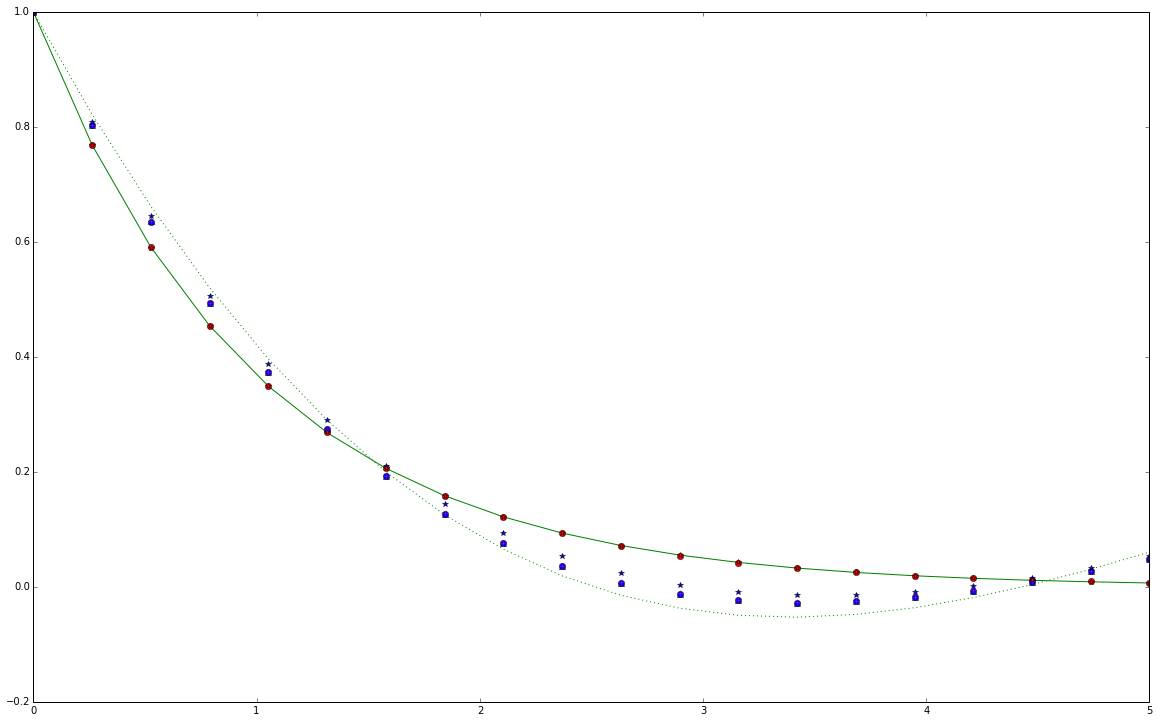

In [70]:
plt.figure(figsize=(20,12.36))
plt.plot(tlinplt,funY(tlinplt),'g-')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacNCG.get('x') ),tlinplt,1),'c^')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacCG.get('x') ),tlinplt,1),'g:')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacSLSQP.get('x') ),tlinplt,1),'ro')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacLBFGSB.get('x') ),tlinplt,1),'bo')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacTNC.get('x') ),tlinplt,1),'m+')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacLBFGSB2.get('x') ),tlinplt,1),'b*')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacSLSQP2.get('x') ),tlinplt,1),'r*')
# plt.yscale('log')
plt.show()

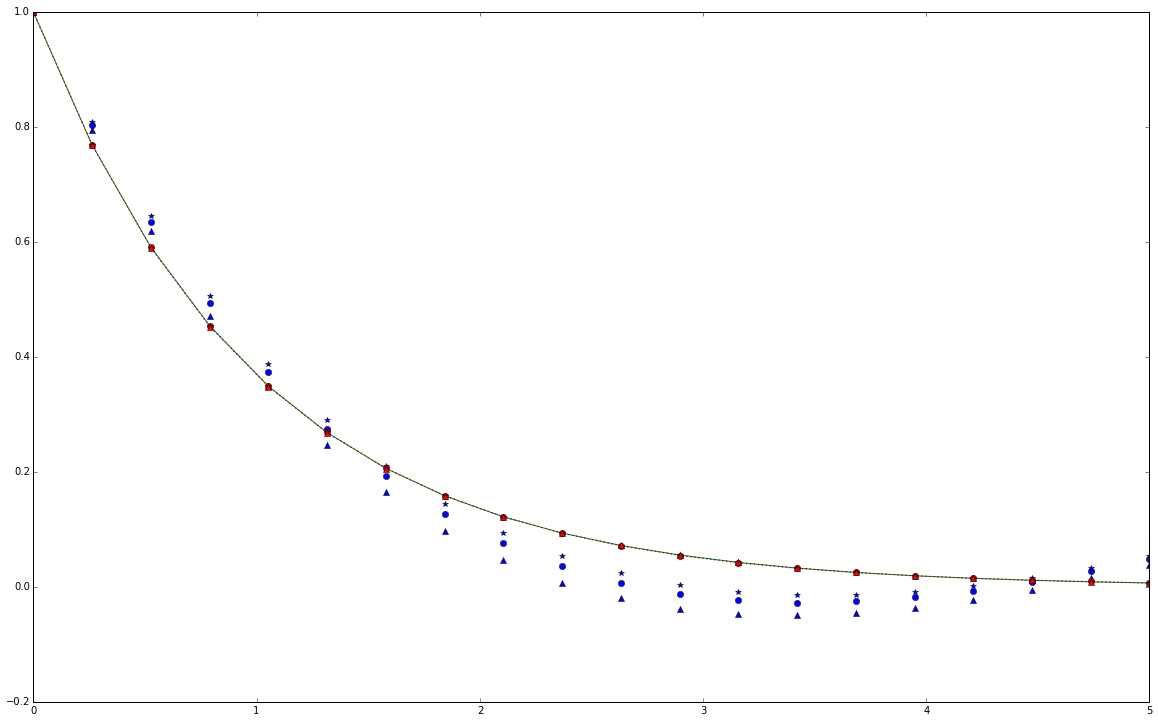

In [76]:
plt.figure(figsize=(20,12.36))
plt.plot(tlinplt,funY(tlinplt),'g-')
plt.plot(tlinplt,funNNList(np.array( costODEFResultLBFGSB.get('x') ),tlinplt,1),'b:')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacLBFGSB.get('x') ),tlinplt,1),'bo')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacLBFGSB2.get('x') ),tlinplt,1),'b*')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacLBFGSB3.get('x') ),tlinplt,1),'b^')
plt.plot(tlinplt,funNNList(np.array( costODEFResultSLSQP.get('x') ),tlinplt,1),'r:')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacSLSQP.get('x') ),tlinplt,1),'ro')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacSLSQP2.get('x') ),tlinplt,1),'r*')
plt.plot(tlinplt,funNNList(np.array( costODEResultJacSLSQP3.get('x') ),tlinplt,1),'r^')
# plt.yscale('log')
plt.show()

# plt.figure(figsize=(20,12.36))
# plt.plot(tlinplt2,funY(tlinplt2),'g-')
# plt.plot(tlinplt2,funNNList(np.array( costODEFResultLBFGSB.get('x') ),tlinplt2,1),'b:')
# plt.plot(tlinplt2,funNNList(np.array( costODEResultJacLBFGSB.get('x') ),tlinplt2,1),'bo')
# plt.plot(tlinplt2,funNNList(np.array( costODEResultJacLBFGSB2.get('x') ),tlinplt2,1),'b*')
# plt.plot(tlinplt2,funNNList(np.array( costODEResultJacLBFGSB3.get('x') ),tlinplt2,1),'b^')
# plt.plot(tlinplt2,funNNList(np.array( costODEFResultSLSQP.get('x') ),tlinplt2,1),'r:')
# plt.plot(tlinplt2,funNNList(np.array( costODEResultJacSLSQP.get('x') ),tlinplt2,1),'ro')
# plt.plot(tlinplt2,funNNList(np.array( costODEResultJacSLSQP2.get('x') ),tlinplt2,1),'r*')
# plt.plot(tlinplt2,funNNList(np.array( costODEResultJacSLSQP3.get('x') ),tlinplt2,1),'r^')
# plt.yscale('log')
# plt.show()

<a id='summary'></a>
-----
## [Summary](#summary) | [toc](#toc)


To tests the time increase as dimension increases.

1. Compare the numerical Jac and analytical Jac trends.

In [132]:
tlin4 = np.linspace(0,5,11)

costODEJacF4 = lambda x: costJac(np.split(x,3)[0],np.split(x,3)[1],np.split(x,3)[2],tlin4)
costODEF4 = lambda x: costODE(x,tlin4,1,yOft)

dim = np.linspace(10,300,11)*3
print dim

[  30.  117.  204.  291.  378.  465.  552.  639.  726.  813.  900.]


In [133]:
# Play with the 

# %%snakeviz
resultdim = np.asarray([])
vwuDimTest = np.linspace(10,300,11)*3
    
for dimele in vwuDimTest:
    
    initGuessJ4 = np.zeros(dimele)
    
    startJacSLSQP4 = timeit.default_timer()
    costODEResultJacSLSQP4 = minimize(costODEF4,initGuessJ4,method="SLSQP",jac=costODEJacF4)
    stopJacSLSQP4 = timeit.default_timer()
    
    resultdim = np.append(resultdim, stopJacSLSQP4 - startJacSLSQP4)
    
    print stopJacSLSQP4 - startJacSLSQP4, costODEResultJacSLSQP4.get("fun"), costODEResultJacSLSQP4.get("success")
    
print resultdim


0.623954057693 1.08024826697e-05 True
1.16640520096 1.35058753539e-06 True
4.1815290451 1.58370900842e-07 True
8.39232397079 4.94832263067e-07 True
16.0506448746 6.67396785998e-06 True
40.4828448296 4.17348311169e-06 True
61.232724905 3.5066461297e-05 True
106.302225113 4.61129888585e-05 True
242.989250183 2.25098747509e-05 False
362.700165987 0.000110150535298 False
527.457528114 4.38909088929e-05 True
[   0.62395406    1.1664052     4.18152905    8.39232397   16.05064487
   40.48284483   61.23272491  106.30222511  242.98925018  362.70016599
  527.45752811]


In [146]:
np.savetxt('./assets/dataTest_ResultDim.txt', resultdim, delimiter = ',')

In [148]:
resultdim = np.genfromtxt('./assets/dataTest_ResultDim.txt', delimiter = ',')

In [156]:
plt.figure(figsize=(20,12.36))
plt.ylabel('Time needed')
plt.xlabel('Dimension of total uvw array')
plt.plot(vwuDimTest,resultdim,"b4-",label="ANN-test-figMethod-TimeTest-InitGuess")
py.iplot_mpl(plt.gcf(),filename="ANN-test-figMethod-TimeTest-InitGuess")

# tls.embed("https://plot.ly/~emptymalei/73/")

In [157]:
plt.figure(figsize=(20,12.36))
plt.ylabel('Time needed')
plt.xlabel('Dimension of total uvw array')
plt.plot(vwuDimTest,resultdim,"b4-",label="ANN-test-figMethod-TimeTest-InitGuess")
plt.yscale('log')
py.iplot_mpl(plt.gcf(),filename="ANN-test-figMethod-TimeTest-InitGuess-log")


In [118]:
np.linspace(10,120,12)

array([  10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
        100.,  110.,  120.])

In [161]:
# %%snakeviz
resultdim2 = np.asarray([])

initGuessJ5 = np.zeros(30)

timeseg = np.linspace(10,120,12)

for dim5 in timeseg:
    
    tlin5 = np.linspace(0,5,dim5)
    
    costODEJacF5 = lambda x: costJac(np.split(x,3)[0],np.split(x,3)[1],np.split(x,3)[2],tlin5)
    costODEF5 = lambda x: costODE(x,tlin5,1,yOft)

    startJacSLSQP5 = timeit.default_timer()
    costODEResultJacSLSQP5 = minimize(costODEF5,initGuessJ5,method="SLSQP",jac=costODEJacF5)
    stopJacSLSQP5 = timeit.default_timer()
    
    resultdim2 = np.append(resultdim2, stopJacSLSQP5 - startJacSLSQP5)
    
    print stopJacSLSQP5 - startJacSLSQP5, costODEResultJacSLSQP5.get("fun"), costODEResultJacSLSQP5.get("success")
    
print resultdim2


0.401245117188 2.9421126197e-05 True
0.720057964325 2.17825387004e-05 True
1.42888689041 7.82736267945e-05 True
1.29306983948 3.79683866651e-05 True
2.04963111877 0.000174305034917 True
2.81797814369 9.11683414227e-05 True
3.6012969017 1.69136614353e-05 True
4.36051607132 2.2770805775e-05 True
5.8360748291 5.92628131519e-06 True
5.01994013786 0.000154569412299 True
5.30923199654 0.000284399212198 True
9.28647613525 7.91642545381e-05 True
[ 0.40124512  0.72005796  1.42888689  1.29306984  2.04963112  2.81797814
  3.6012969   4.36051607  5.83607483  5.01994014  5.309232    9.28647614]


In [162]:
# np.savetxt('./assets/dataTest_ResultDim2.txt', resultdim2, delimiter = ',')

In [163]:
resultdim2 = np.genfromtxt('./assets/dataTest_ResultDim2.txt', delimiter = ',')

In [164]:
plt.figure(figsize=(20,12.36))
plt.ylabel('Time needed')
plt.xlabel('Dimension of time array')
plt.plot(timeseg,resultdim2,"b4-",label="ANN-test-figMethod-TimeTest-TimeSeg")

py.iplot_mpl(plt.gcf(),filename="ANN-test-figMethod-TimeTest-TimeSeg")

# tls.embed("https://plot.ly/~emptymalei/")

In [165]:
plt.figure(figsize=(20,12.36))
plt.ylabel('Time needed')
plt.xlabel('Dimension of time array')
plt.plot(timeseg,resultdim2,"b4-",label="ANN-test-figMethod-TimeTest-TimeSeg")
plt.yscale('log')

py.iplot_mpl(plt.gcf(),filename="ANN-test-figMethod-TimeTest-TimeSeg-log")


**To summarize, **

1. CG is extremely fast, however, it's not so accurate.
2. SLSQP is also very fast, and it is very accurate
3. L-BFGS-B gives us the best result and it's not slow.

|  Method  |                Time                |                      Function                     |                nfev/njev                |        nit        |
|:--------:|:----------------------------------:|:-------------------------------------------------:|:---------------------------------------:|:-----------------:|
|    CG    | 2.95948886871(Jac: 0.341506004333) |    0.1920503701634634(Jac: 0.19205041475267956)   |  nfev: 492,njev: 15 (nfev: 27,njev: 15) |                   |
|   SLSQP  |  10.7389249802(Jac:0.955240011215) | 2.5774431624374406e-05(Jac:1.080248266970841e-05) | nfev: 1649,njev: 51 (nfev: 66,njev: 51) |  nit: 51(nit: 51) |
| L-BFGS-B |   18.576128006(Jac:8.60380482674)  |  1.6905137501642895e-07(Jac:0.093712249132977959) |           nfev: 119(nfev: 466)          | nit: 93(nit: 358) |
|    N-M   |            30.9348311424           |               0.00031884090490975285              |                nfev: 6001               |                   |
|    NCG   |         (Jac:37.292183876)         |               (0.09397294690879396)               |          (njev: 3149,nfev: 526)         |                   |



* Smaller vwu dimensions, less time? True for SLSQP Jac. 
* Seems that by solving an equation, we are solving a equation **in a particular region** with a specific initial condition. **Be careful with extrapolation.**

### Plotting

Here in this section I def some function used to plot the data.

The plot function outputs a plot with inputs of a list of ts and ys.

In [ ]:
startTemp = timeit.default_timer()
testArraySplit = np.zeros(30)
np.split(testArraySplit,3)[0]
np.split(testArraySplit,3)[1]
np.split(testArraySplit,3)[2]
stopTemp = timeit.default_timer()
print stopTemp - startTemp

In [ ]:
print tlin2
print tlin

In [ ]:
x1 = np.zeros(30)
v1, w1, u1 = np.split(x1,3)[:3]
print v1, w1